In [1]:
import pandas as pd
import numpy as np
import glob
from scipy import stats
import matplotlib.pyplot as plt

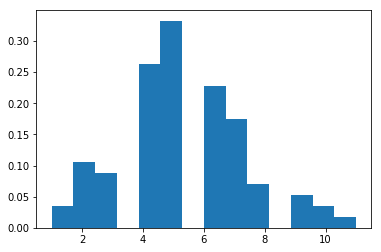

In [35]:
s = np.random.poisson(5, 80)
s.sort()
count, bins, ignored = plt.hist(s, 14, density=True)

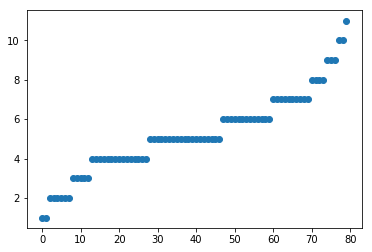

In [36]:
trial = np.arange(len(s))
discoveryTime = s

df = pd.DataFrame({'trialNum': trial, 'DiscoveryTime': discoveryTime})
plt.scatter(df.trialNum, df.DiscoveryTime)

In [37]:
def permuteData(NumPermute, data):
    # preallocate shape of permutedTrials 
    a = np.arange(NumPermute)
    b = np.arange(len(data.index))
    tuples = [(p1, p2) for p1 in a for p2 in b]

    index = pd.MultiIndex.from_tuples(tuples, names=['permuteNumber', 'df_index'])
    permuted_df = pd.DataFrame(data = None, index=index, columns = ['trialNum', 'DiscoveryTime'])
    
    # permute and fillIN
    idx = pd.IndexSlice
    for permuteNum in range(1000):
        permutedTrials = np.random.permutation(data.trialNum)
        permuted_df.loc[idx[permuteNum, :], 'DiscoveryTime'] = data.DiscoveryTime.values.copy()
        permuted_df.loc[idx[permuteNum, :], 'trialNum'] = permutedTrials
        
    return(permuted_df)

In [38]:
outpath = './dataFolders/Output/Step8_PDFs and KL Divergence/'

In [39]:
# specify parameters that are used
# specifying binning size and last edge
binsize = 4
max_bin_Edge = 40

# number of bins for describing distribution
nbin = 25
shapes = ['c-1', 'c-2', 'c-3', 'c-10']

In [40]:
# randomly permute 
NumOfPermutes = 1000
permute = permuteData(NumOfPermutes, data=df)
permute.to_csv(outpath + 'permuted_df_PoissonDistribution.csv')

In [41]:
def CalcKLDivergence(bin_id, NumOfPermutes, test_df, Q_dist):
# calculate KL divergence for permuted bins

    # build the KL matrix for permutated data
    columns = bin_id[1:]
    index = np.arange(NumOfPermutes)
    KL_matrix = pd.DataFrame(data = None, index=index, columns = columns)
    KL_matrix = KL_matrix.astype(np.float)
    KL_matrix.head()

    # get the KL divergence for permuted dataset
    for binEdge in columns:
        for permuteNum in range(NumOfPermutes):
                test_data = test_df.loc[test_df.index.get_level_values('permuteNumber') == permuteNum, :, 
                                            test_df.trialNum < binEdge].DiscoveryTime.values/100
                P_dist, _ = np.histogram(test_data, bins = bin_hist)
                epsilon = 1e-30
                P = P_dist + epsilon
                Q = Q_dist + epsilon
                KL = stats.entropy(P, Q)
                KL_matrix.loc[permuteNum,binEdge] = KL
    return KL_matrix

In [50]:
bin_id = np.arange(0,40, binsize)
bin_id = np.append(bin_id,max(df.trialNum)+1)

# reference flower data
ref_data = df.DiscoveryTime.values/100 
Q_dist, bin_hist = np.histogram(ref_data, bins = nbin)

In [42]:
KL_permute = CalcKLDivergence(bin_id=bin_id, NumOfPermutes=1000, Q_dist= Q_dist, test_df= permute)

In [43]:
CI = np.percentile(KL_permute, [5, 95], axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=True)

In [44]:
# calculate KL divergence for true distribution in df

columns = bin_id[1:]
KL_data = pd.Series(data = None, index = columns, dtype = 'float64')

for binEdge in columns:
    test_data = df.loc[df.trialNum < binEdge].DiscoveryTime.values/100
    P_dist, _ = np.histogram(test_data, bins = bin_hist)
    epsilon = 1e-30
    P = P_dist + epsilon
    Q = Q_dist + epsilon
    KL = stats.entropy(P, Q)
    KL_data.loc[binEdge] = KL

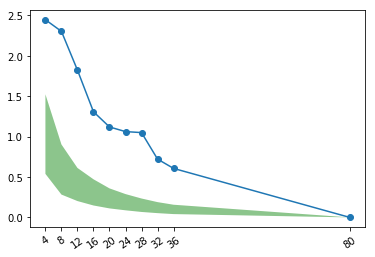

In [46]:
# plot them together
plt.plot(columns, KL_data, marker = 'o')
plt.fill_between(columns, CI[0,:][0], CI[1,:][0], facecolor = 'green', alpha = 0.45)
plt.xticks(columns)
plt.xticks(rotation=35)

plt.savefig('./dataFolders/Output/Figures/Distributions/Poisson_dist_KL_continousBins.png')

In [65]:
def CalcKLDivergence_binEdge(bin_id, NumOfPermutes, Q_dist, permuted_df):
    columns = bin_id[1:]
    index = np.arange(NumOfPermutes)
    KL_matrix = pd.DataFrame(data = None, index=index, columns = columns)
    KL_matrix = KL_matrix.astype(np.float)
    KL_matrix.head()

    # now lets do build our KL divergence 95% confidence interval

    # get the KL divergence for permuted dataset
    for binEdge in columns:
        for permuteNum in range(NumOfPermutes):
                test_data = permuted_df.loc[permuted_df.index.get_level_values('permuteNumber') == permuteNum, :,
                                            (permuted_df.trialNum < binEdge)].DiscoveryTime.values/100
                P_dist, _ = np.histogram(test_data, bins = bin_hist)
                epsilon = 1e-30
                P = P_dist + epsilon
                Q = Q_dist + epsilon
                KL = stats.entropy(P, Q)
                KL_matrix.loc[permuteNum,binEdge] = KL
    return(KL_matrix)

In [58]:
permute.head()

trialNum  DiscoveryTime
permuteNumber df_index                         
0             0               71              1
              1               28              1
              2               30              2
              3                9              2
              4               47              2

In [67]:
# for binnedDataset

bin_id = np.arange(0,25, binsize)
bin_id = np.append(bin_id,max(df.trialNum)+1)
columns = bin_id[1:]

# reference flower data
ref_data = df.loc[df.trialNum > 25, 'DiscoveryTime' ].values/100 
Q_dist, bin_hist = np.histogram(ref_data, bins = nbin)


# build the KL matrix for permutated data
KL_permute_binEdge = CalcKLDivergence_binEdge(bin_id=bin_id, NumOfPermutes=1000, Q_dist=Q_dist, permuted_df=permute)

In [68]:
CI = np.percentile(KL_permute_binEdge, [5, 95], axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=True)

In [69]:
# get the KL divergence for the real data
KL_data_binEdge = pd.Series(data = None, index = columns, dtype = 'float64')

for binEdge in columns:
    test_data = df.loc[df.trialNum < binEdge].DiscoveryTime.values/100
    P_dist, _ = np.histogram(test_data, bins = bin_hist)
    epsilon = 1e-30
    P = P_dist + epsilon
    Q = Q_dist + epsilon
    KL = stats.entropy(P, Q)
    KL_data_binEdge.loc[binEdge] = KL

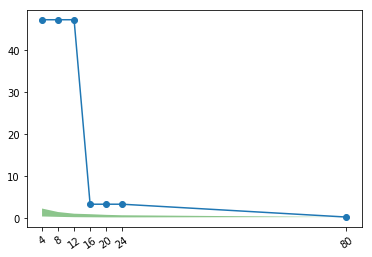

In [70]:
# plot them together
plt.plot(columns, KL_data_binEdge, marker = 'o')
plt.fill_between(columns, CI[0,:][0], CI[1,:][0], facecolor = 'green', alpha = 0.45)
plt.xticks(columns)
plt.xticks(rotation=35)

plt.savefig('./dataFolders/Output/Figures/Distributions/Poisson_dist_KL_BinEdge.png')